<span style="color:gray">Интеллектуальный анализ данных в R и Python. Лекция 5</span>

### 6.  Обучение с учителем. Метод опорных векторов.

<font color='blue'>Метод опорных векторов</font> (Support Vector Machine, SVM) решает следующую проблему оптимизации:

$$
\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i,  \quad y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i, \quad \zeta_i \geq 0, i=1, ..., n
$$

где $ \{x_1, \dots, x_n \} $ обучающие примеры являются целевой функцией $ y \in \{- 1,1 \} $. Алтернативное представление в виде двойственной задачи имеет вид:

$$
\min_{\alpha} \frac{1}{2} \alpha^T Q \alpha - e^T \alpha, \quad y^T \alpha = 0, \quad 0 \leq \alpha_i \leq C, i=1, ..., n
$$


Мы будем использовать SVM, реализованный в функции [`sklearn.svm.SVC`] (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), которая использует встроенную библиотеку [`libsvm`] (https://www.csie.ntu.edu.tw/~cjlin/libsvm/).

Вместо функции [`sklearn.svm.SVC.predict_proba ()`] (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba), которая возвращает вероятности для каждого класса (от 0 до 1), для SVM мы будем использовать [`sklearn.svm.SVC.decision_function()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.decision_function), которая возвращает расстояние от разделяющей гиперплоскости. 

Пример использования приведен в официальной scikit-learn документации [SVM: Maximum margin separating hyperplane](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py).

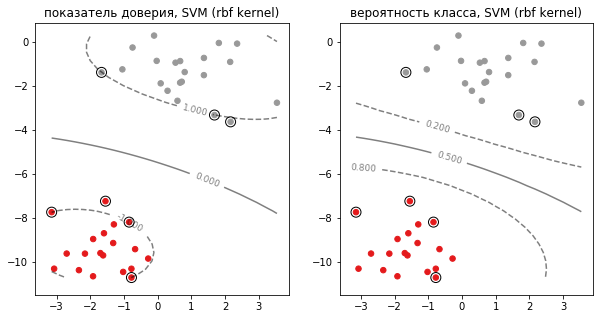

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn import svm

def calculate_decision_function(X,model):
    '''
    Create a 2D grid to evaluate model.
    '''

    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model(xy).reshape(XX.shape)

    return (XX,YY,Z)

# генерируем 60 примеров
X, y = make_blobs(n_samples=60, centers=2, cluster_std=1.0, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# обучаем модель без регуляриазции параметров
kernel = 'rbf' # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
model = Pipeline([('SVM', svm.SVC(kernel=kernel, probability=True))]) 
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    ax[i].scatter(X_train[:,0], X_train[:,1], c=y_train, s=30, cmap=plt.cm.Set1)
    # строим опорные вектора
    ax[i].scatter(model.named_steps['SVM'].support_vectors_[:,0], model.named_steps['SVM'].support_vectors_[:,1], 
                  s=100, linewidths=1, edgecolors='black', facecolors='none')

# строим линии уровня показателя доверия 
(XX,YY,Z) = calculate_decision_function(X_train, model.decision_function)
CS = ax[0].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax[0].clabel(CS, fontsize=9, inline=1)
ax[0].set(title='показатель доверия, SVM (' + kernel + ' kernel)')
    
# строим линии уровня вероятности принадлежности к классу
(XX,YY,Z) = calculate_decision_function(X_train, lambda x: model.predict_proba(x)[:,0])
CS = ax[1].contour(XX, YY, Z, colors='k', levels=[0.2, 0.5, 0.8], alpha=0.5, linestyles=['--', '-', '--'])
ax[1].clabel(CS, fontsize=9, inline=1)
ax[1].set(title='вероятность класса, SVM (' + kernel + ' kernel)')

plt.show();

#### Регуляриазция модели с учетом параметров модели $C$ и $\gamma$.

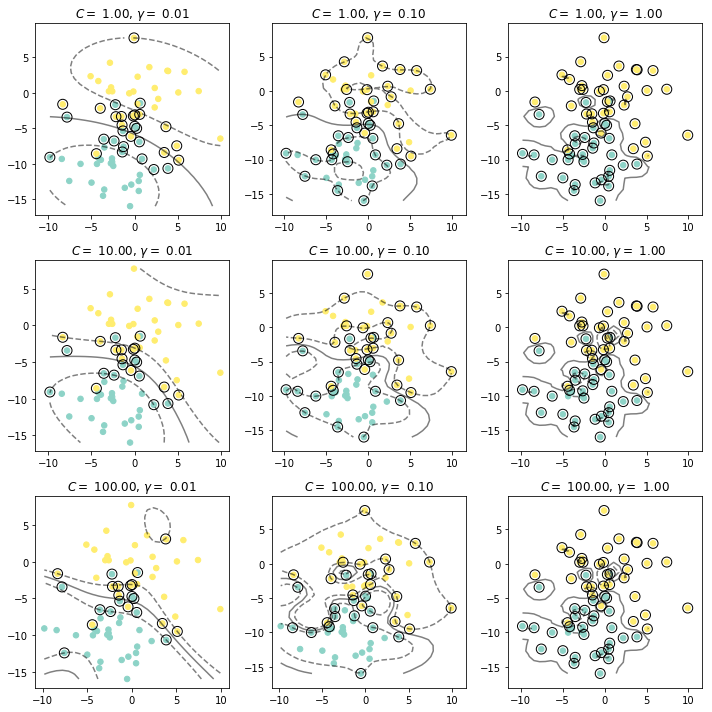

In [12]:
#X, y = make_blobs(n_samples=70, centers=2, cluster_std=2.0, random_state=2)
#X, y = make_blobs(n_samples=100, centers=2, cluster_std=2.0, random_state=2)
X, y = make_blobs(n_samples=70, centers=2, cluster_std=3.5, random_state=2)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i,C in enumerate([1.0,10.0,100.0]):
    for j,gamma in enumerate([0.01,0.1,1.0]):
          
        model = Pipeline([('SVM', svm.SVC(kernel='rbf', C=C, gamma=gamma))]) 
        model.fit(X, y)

        ax[i][j].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Set3)

        # Plotanje decizijske funkcije i confidence scorea
        (XX,YY,Z) = calculate_decision_function(X, model.decision_function)
        CS = ax[i][j].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

        # Plotanje potpornih vektora
        ax[i][j].scatter(model.named_steps['SVM'].support_vectors_[:, 0], model.named_steps['SVM'].support_vectors_[:, 1], 
                         s=100, linewidths=1, edgecolors='black', facecolors='none')
        ax[i][j].set(title='$C=$ '+'{0:.2f}'.format(C)+', $\gamma =$ '+'{0:.2f}'.format(gamma))


fig.tight_layout();

<font color='green'>Задание для самостоятельной работы:</font>

1. Реализовать метод опорных векторов на реальном наборе данных, запуская ячейки в данном Jupyter Notebook и меняя значения параметров модели. 
1. Создать ячейку и написать пояснение, как параметры модели $C$ и $\gamma$ влияют на качество модели SVM. 
1. Загрузить резунльтирующий .ipynb файл в папку /assignments/. Файлы должны именоваться как:<br>
   *'Lecture_5_' + surname*.

#### Влияение параметров $C$ и $\gamma$  

На основе полученных итераций (изменений параметров модели) и графиков: Увеличение параметра $C$ и $\gamma$ ведет к увеличению качества модели, но только до некоторого предела, после которого качество стремительно падает. Также изменение параметра $\gamma$ прямо пропорционально влияет на т.н. расстояние между базовым вектором и гиперплоскостью.